### Predict severity of service disruptions on Telestra Network
> Nature of dataset : Service Logs.
> Predict whether disruption is a momentary glitch or a total interruption of activity.
> Telestra is putting efforts into predicting timing and scope of such disruptions.

### Objective

The goal of the problem is to predict Telstra network's _fault severity_ at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the __id__ column, which is the key __id__ used in other data files. 

Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). 

Different types of features are extracted from log files and other sources: event_type.csv, log_feature.csv, resource_type.csv, severity_type.csv. 

Note: __severity_type__ is a feature extracted from the log files (in severity_type.csv). Often this is a severity type of a warning message coming from the log. __severity_type__ is categorical. It does not have an ordering. __fault_severity__ is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

** File Descriptions **

* train.csv - the training set for fault severity
* test.csv - the test set for fault severity
* sample_submission.csv - a sample submission file in the correct format
* event_type.csv - event type related to the main dataset
* log_feature.csv - features extracted from log files
* resource_type.csv - type of resource related to the main dataset
* severity_type.csv -  severity type of a warning message coming from the log

** Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). **

In [3]:
%matplotlib inline
from __future__ import division

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
# load train and test files
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [5]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


** Each row is uniquely represented by an `id` and represent time and location **

In [6]:
test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [14]:
# load other files
event_types = pd.read_csv('../data/event_type.csv')
log_features = pd.read_csv('../data/log_feature.csv')
resource_types = pd.read_csv('../data/resource_type.csv')
severity_types = pd.read_csv('../data/severity_type.csv')

In [15]:
event_types.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


** How many different types of event types are present in the dataset ? **

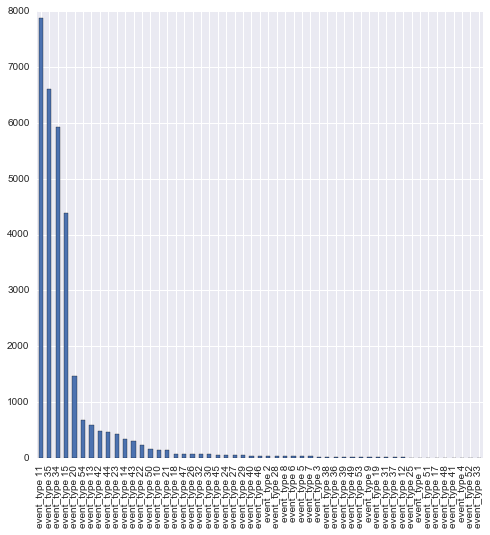

In [16]:
plt.figure(figsize=(8, 8))
event_types.event_type.value_counts().plot(kind='bar');

** Some event types are most common and rest occur less frequently. **

** Is there any relationship between event types and the ids ? **

In [17]:
g = event_types.groupby('id').size()
g.describe()

count    18552.000000
mean         1.680142
std          0.716816
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         11.000000
dtype: float64

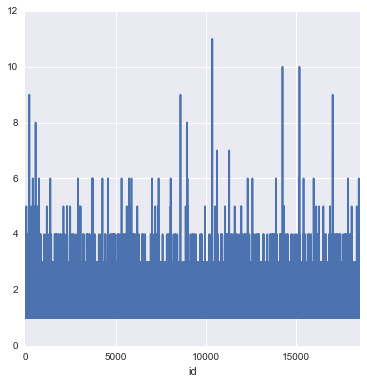

In [18]:
plt.figure(figsize=(6, 6))
g.plot();

** Most of the ids have 2 or 3 events registered against it but some have many events registered **

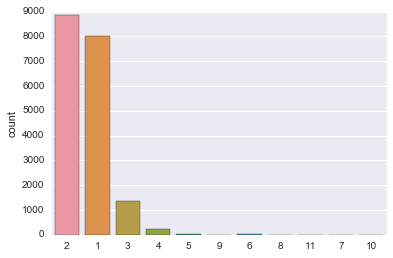

In [19]:
sns.countplot(g.values);

** Most of the ids have 1 or 2 event types associated with them **

In [20]:
log_features.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [25]:
log_features.log_feature.value_counts()

feature 312    5267
feature 232    4754
feature 82     3472
feature 203    2823
feature 313    2145
feature 233    1901
feature 307    1597
feature 54     1573
feature 170    1526
feature 71     1514
feature 315    1495
feature 134    1419
feature 80     1336
feature 235    1294
feature 193    1160
feature 219    1152
feature 68     1093
feature 227    1080
feature 314     950
feature 201     902
feature 234     882
feature 73      868
feature 195     783
feature 301     707
feature 309     627
feature 55      564
feature 229     560
feature 273     491
feature 308     484
feature 368     462
               ... 
feature 16        1
feature 271       1
feature 175       1
feature 272       1
feature 263       1
feature 254       1
feature 257       1
feature 250       1
feature 252       1
feature 382       1
feature 386       1
feature 385       1
feature 96        1
feature 3         1
feature 144       1
feature 260       1
feature 262       1
feature 17        1
feature 379       1


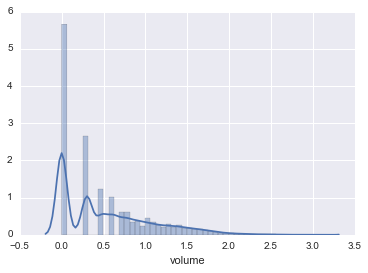

In [27]:
sns.distplot(log_features.volume.map(np.log10));

In [10]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [11]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1
